# Importance sampling

In this notebook, we use importance sampling to approximate the posterior distribution of the latent variables in a Non-Markovian Gaussian sequence model.

We consider a non-Markovian Gaussian sequence model (NM-GSM) of the form

$$
\begin{aligned}
    f_t(x_t \vert x_{t-1}) &= \mathcal{N}(x_t \vert \phi x_{t-1}, q),\\
    g_t(y_t \vert x_{1:t}) &= \mathcal{N}\left(y_t \big\vert \sum_{k=1}^t \beta^{t-k} x_k, r\right).
\end{aligned}
$$

Suppose we know the values $\boldsymbol\theta = (\phi, q, \beta, r)$ that govern the sequence model. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import distrax
import seaborn as sns
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jsmc.datagen import non_markovian_gsm as nmgsm

In [3]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

## Sampling NM-GSM

In [4]:
key = jax.random.PRNGKey(314)
num_steps = 20
params = nmgsm.ModelParameters(phi=0.0, q=0.4, beta=0.0, r=2.0)
simulation = nmgsm.simulate(key, params, num_steps)

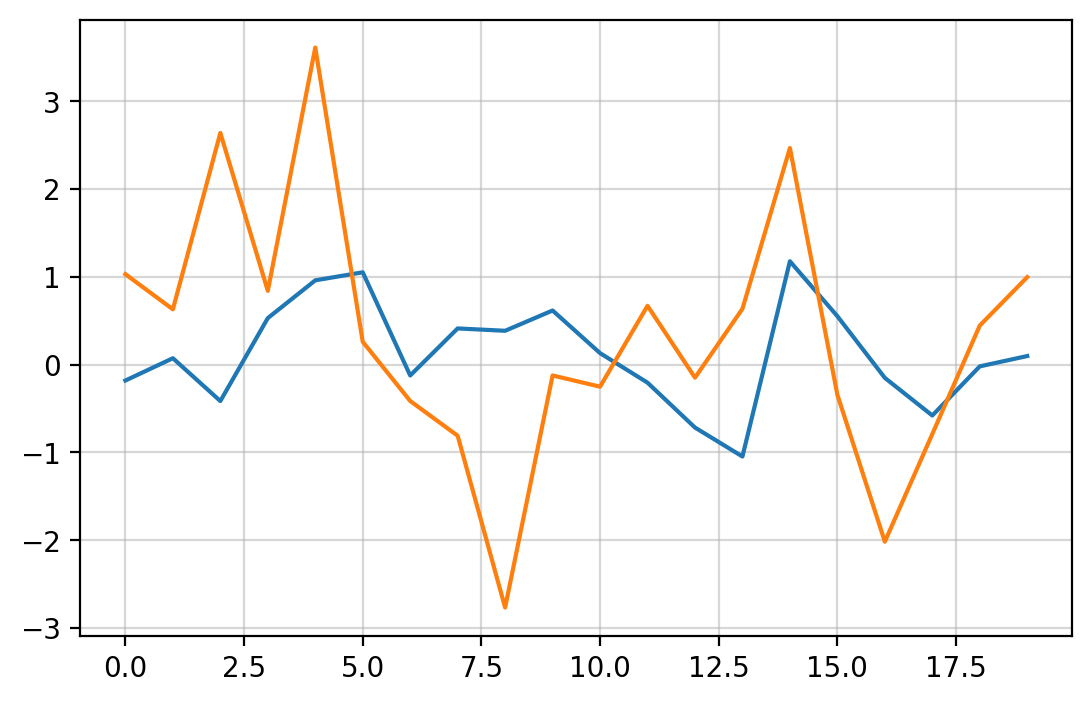

In [5]:
plt.plot(simulation.x)
plt.plot(simulation.y)
plt.grid(alpha=0.5)

## Posterior estimation

In [6]:
vals = jnp.tri(num_steps)

In [7]:
def step_target_t(carry_row, row, beta=2):
    """
    Building non-markovian ssm: one row at a time
    """
    carry_row = carry_row * beta + row
    return carry_row, carry_row

In [8]:
num_steps_test= 10
init_row = jnp.zeros(num_steps_test)
vals = jnp.eye(num_steps_test)

jax.lax.scan(step_target_t, init_row, vals)[1]

DeviceArray([[  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
             [  2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
             [  4.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
             [  8.,   4.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
             [ 16.,   8.,   4.,   2.,   1.,   0.,   0.,   0.,   0.,   0.],
             [ 32.,  16.,   8.,   4.,   2.,   1.,   0.,   0.,   0.,   0.],
             [ 64.,  32.,  16.,   8.,   4.,   2.,   1.,   0.,   0.,   0.],
             [128.,  64.,  32.,  16.,   8.,   4.,   2.,   1.,   0.,   0.],
             [256., 128.,  64.,  32.,  16.,   8.,   4.,   2.,   1.,   0.],
             [512., 256., 128.,  64.,  32.,  16.,   8.,   4.,   2.,   1.]],            dtype=float32)

## Evaluating log-joint

In [9]:
@partial(jax.vmap, in_axes=(0, None, None, None))
def get_log_weights(x_latent, y_obs, params, proposal):
    return nmgsm.log_joint(x_latent, y_obs, params) - proposal.log_prob(x_latent)

In [10]:
params = nmgsm.ModelParameters(phi=0.0, q=1.0, beta=0.0, r=1.0)
simulation = nmgsm.simulate(key, params, num_steps)

In [11]:
mean_proposal = jnp.zeros(num_steps)
scale_proposal = jnp.ones(num_steps) 
proposal = distrax.MultivariateNormalDiag(loc=mean_proposal, scale_diag=scale_proposal)
x_prop = proposal.sample(seed=key)

In [12]:
nmgsm.log_joint(simulation.x, simulation.y, params)

DeviceArray(-55.960705, dtype=float32)

In [13]:
n_particles = 5_000
scale_proposal = jnp.ones(num_steps)
x_prop = proposal.sample(seed=key, sample_shape=(n_particles,))
log_weights = get_log_weights(x_prop, simulation.y, params, proposal)

In [14]:
logz = jax.vmap(nmgsm.log_joint, in_axes=(0, None, None))(x_prop, simulation.y, params)
logz_true = nmgsm.log_joint(simulation.x, simulation.y, params)
logz_diff = logz - logz_true

In [15]:
weights = jnp.exp(log_weights - jax.nn.logsumexp(log_weights))
x_est = jnp.einsum("sm,s->m", x_prop, weights)

In [16]:
nmgsm.log_joint(simulation.x, simulation.y, params)

DeviceArray(-55.960705, dtype=float32)

In [17]:
nmgsm.log_joint(x_est, simulation.y, params)

DeviceArray(-45.760075, dtype=float32)

<AxesSubplot: ylabel='diff'>

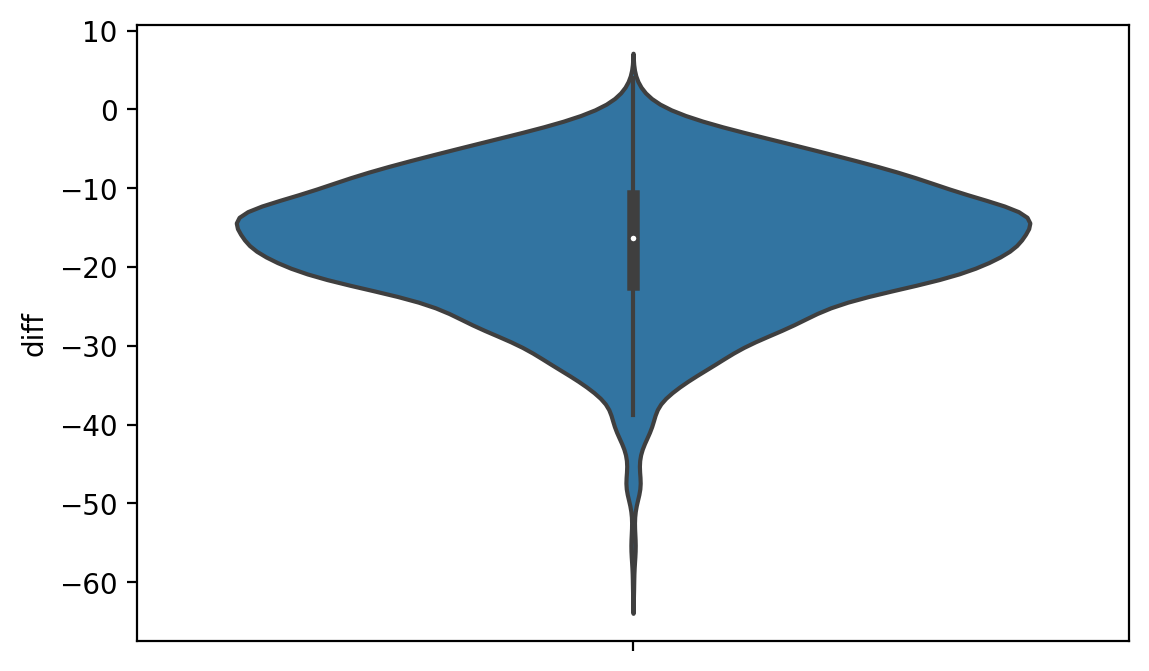

In [18]:
df = pd.DataFrame({
    "diff": logz_diff.to_py(),
    "weights": weights.to_py()
})

sns.violinplot(y="diff", weights="weights", data=df, bins=50)